## Load important libraries

### If error -> prbably package is not installed

### If using notebook insted of JupyterLab, try '%matplotlib nbagg' and restart the kernel

In [16]:
%matplotlib widget
import h5py as h5  #to open HDF type files
import numpy as np #to work with numeric data
import matplotlib.pyplot as plt #plotting
import pandas as pd

from scipy.ndimage import gaussian_filter, convolve
from skimage.morphology import closing, square

from skimage import io, filters, measure #select and treshold ROIs

## Methods for using cutoffs to determine the optimal intensity threshold


### If not run, the cell generating the binary mask will throw an error

#### generate_cutoffs -> takes in image data for an element, and returns a list of intensity thresholds which generate the highest background separation from highest to lowest

#### optimal_cutoff -> takes in the list off all cutoff values, and returns the one with the largest difference with the next lower value

In [17]:
def generate_cutoffs(data):
    flat_sorted = np.sort(data.flatten())
    cutoffs = []
    while flat_sorted.any():
        differences = []
        if len(flat_sorted) == 1:
            break
        for index, value in enumerate(flat_sorted[:-1]):
            differences.append(flat_sorted[index+1]-value)
        
        cutoff = differences.index(max(differences))+1
        cutoffs.append(cutoff)
        flat_sorted = flat_sorted[:cutoff]
    return [(i/len(data.flatten()))*100 for i in cutoffs]

def optimal_cutoff(cutoffs):
    diff = []
    if len(cutoffs)>1:
        for index, value in enumerate(cutoffs[:-1]):
            diff.append(value - cutoffs[index+1])
        limit = diff.index(max(diff))
    else:
        limit = 0
   
    return cutoffs[limit]

## Data locations

### Make sure the paths of each file is correct on the current machine, otherwise you may get an error here, or later in the script

In [18]:
data_sets = {13:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan13\sdd12346\xrf_flat_scan_13_aligned.h5',
            16: r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan16\sdd12346\xrf_flat_scan_16_aligned.h5',
             20:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan20\sdd12346\xrf_flat_scan_20_aligned.h5',
             25:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan25\sdd12346\xrf_flat_scan_25_aligned.h5',
             28:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan28\sdd12346\xrf_flat_scan_28_aligned.h5',
             30:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan30\sdd12346\xrf_flat_scan_30_aligned.h5',
             41:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan41\sdd12346\xrf_flat_scan_41_aligned.h5',
             47:r'C:\Users\mates\OneDrive - elte.hu\University\Experiments\Trieste\2024\results\results\scan47\sdd12346\xrf_flat_scan_47_aligned.h5',
            }

# Load file

In [19]:
sample = 30 #select the file from the list of available files

f = h5.File(data_sets[sample],'r') #load the .h5 file


# Generate Binary mask

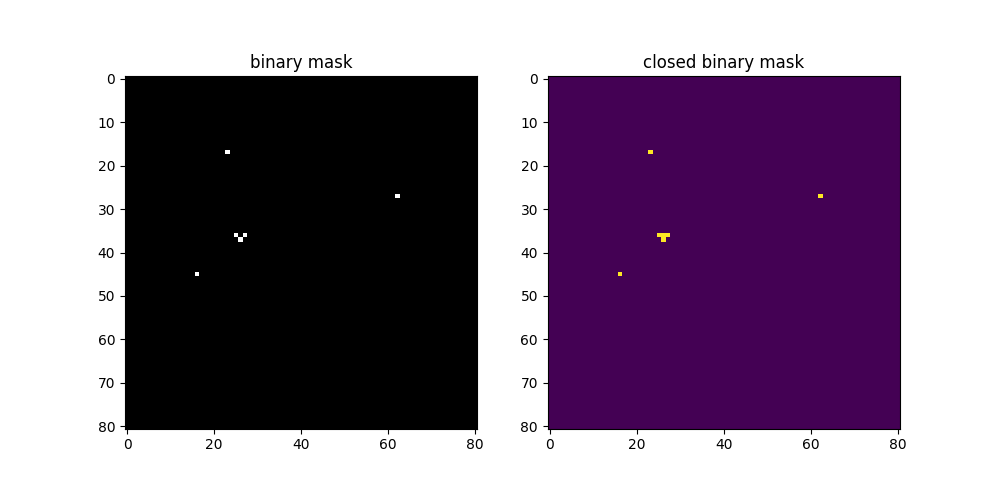

In [20]:
from skimage import restoration
#binary mask to generate for 'Fe_L' 
mask_element = 'Fe_L'
map = f['xrf_flat_scan_{}_aligned'.format(sample)]['xrf_fit']['results']['parameters'][mask_element] #access the signal location in the file
if np.isnan(map).any:
    map = np.nan_to_num(map,nan=np.nanmin(map))

#map = map - restoration.rolling_ball(map, radius=2)
#map = convolve(map, np.array([np.ones(2) for i in range(2)]))
#map = map**2


#data_sqrd = np.array(map) **2 #multiply data with itself
cutoffs = generate_cutoffs(map)

####PARAMETERS
limit = optimal_cutoff(cutoffs) #intensity threshold ---limit is automatically set for this method---
closing_value = 2 #pixel size for closing
closing_bn = False #if True, closing mask becomes binary mask
######

binary_mask = map > np.percentile(map, limit)

        
closed_binary_mask = None  
if closing_value > 0: #closing is optional
    closed_binary_mask = closing(binary_mask, square(closing_value))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title("binary mask")

if closed_binary_mask is not None:
    axes[1].imshow(closed_binary_mask)
    axes[1].set_title("closed binary mask")
    # binary_mask = closed_binary_mask

if closing_bn == True:
    binary_mask = closed_binary_mask

# Apply binary mask, and generate locations

### The elements list must be three items long!
### In the 'ratios' calculation, the first element's intensities will be divided with the second, and third element, respectively

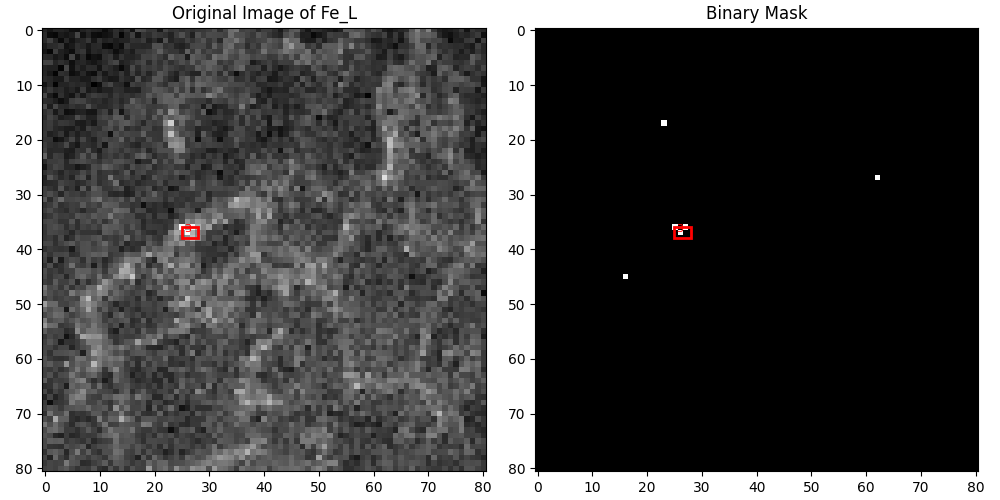

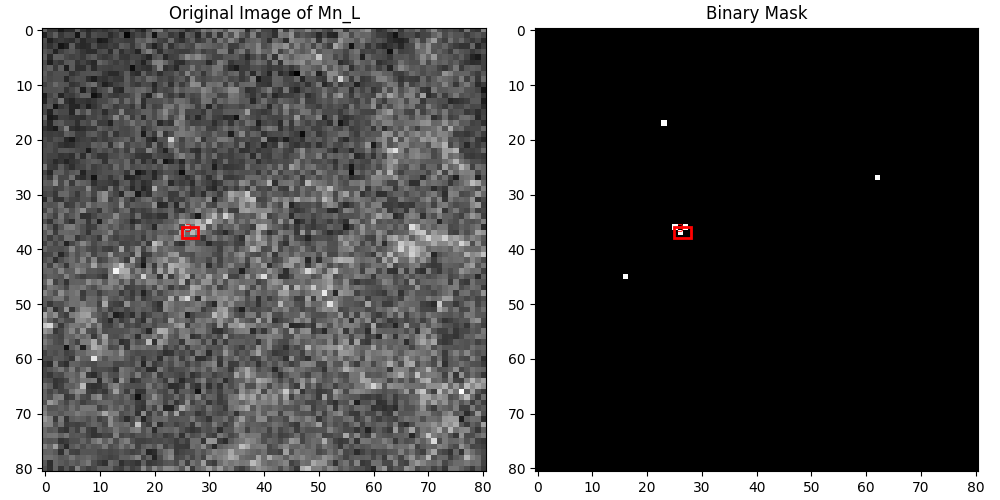

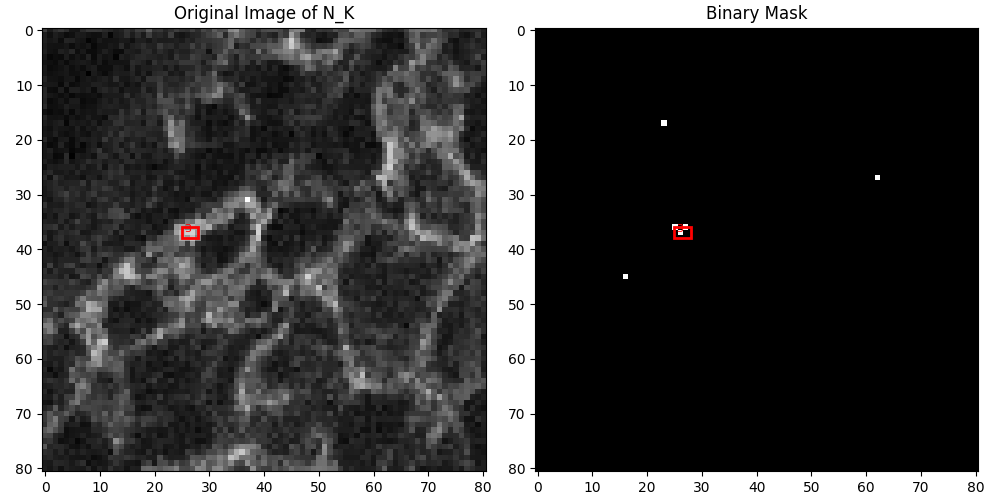

In [26]:
from skimage import io, filters, measure

####parameters####
elements = ['Fe_L', 'Mn_L', 'N_K'] #specify the elements to work with
area_limit = 2 #area size cutoff
####
combined_df = [] #target for numerical values
figs = {} #target for plots

for element in elements:#iterate through elements
    element_map = f['xrf_flat_scan_{}_aligned'.format(sample)]['xrf_fit']['results']['parameters'][element] #open data
    labels = measure.label(binary_mask) #generate labels the masks
    properties = measure.regionprops(labels) #collect their properties
    #plot the elemental map...
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(element_map, cmap='gray')
    axes[0].set_title(f'Original Image of {element}')
    #...and plot the binary mask
    axes[1].imshow(binary_mask, cmap = 'gray')
    axes[1].set_title('Binary Mask')
    figs[element] = fig
    for prop in  properties: #access the properties of each area
        if prop.area > area_limit: #check that the area is over the specified limit
            minr, minc, maxr, maxc = prop.bbox #prepare the coordinates for the bounding boxes
            # Draw rectangles on the original image
            rect1 = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                 fill=False, edgecolor='red', linewidth=2)
            axes[0].add_patch(rect1)

            # Draw rectangles on the binary mask image
            rect2 = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                 fill=False, edgecolor='red', linewidth=2)
            axes[1].add_patch(rect2)

            # Annotate on the original image
            y, x = prop.centroid
            axes[0].text(x, y, prop.label, color='red', fontsize=8, ha='center', va='center')

            # Annotate on the blurred image
            axes[1].text(x, y, prop.label, color='red', fontsize=8, ha='center', va='center')
    #show the plot
    plt.tight_layout()
    plt.show()
    #collect the properties of the masks and assign them as keys for the numeric values for each area
    data = element_map
    roi_data = [
            {
                'Label': prop.label,
                'Area': prop.area,
                'Mean': np.mean(data[prop.slice]),
                'Min': np.min(data[prop.slice]),
                'Max': np.max(data[prop.slice]),
                'SD': np.std(data[prop.slice])
            }
            for prop in properties if prop.area>area_limit
        ]
    #generate a dataframe
    df = pd.DataFrame(roi_data, index=[prop['Label'] for prop in roi_data])
    combined_df.append(df) #and append them to a list
out = dict(zip(elements,combined_df)) #finally generate a dict where the elements are keys and dataframes are values

ratios = pd.DataFrame({
    f'{elements[0]} / {elements[1]}': out[elements[0]]['Mean'] / out[elements[1]]['Mean'],
    f'{elements[0]} / {elements[2]}': out[elements[0]]['Mean'] / out[elements[2]]['Mean']
})

# Generate docx report

In [28]:
import pandas as pd
from pandas.plotting import table
from docx import Document
from docx.shared import Inches
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
from PIL import Image

import os

save_location = f'Sample {sample} data output/cutoff'
if not os.path.isdir(save_location.split('/')[0]):
    os.mkdir(save_location.split('/')[0])
if not os.path.isdir(save_location):
    os.mkdir(save_location)



document = Document()
document.sections[0].left_margin = Inches(0.5)
document.sections[0].right_margin = Inches(0.5)
document.add_heading(f'Sample {sample} report', 0)
document.add_heading('Binary Mask', 1)


Image.fromarray(binary_mask).save(save_location +'/' + 'binary_image.png')
document.add_picture(save_location +'/' + 'binary_image.png', width=Inches(5))
last_paragraph = document.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
document.add_paragraph(f'binary image generated from {mask_element} signal')
document.add_paragraph(f'signal limit was {round(limit,4)} th percentile')

document.add_page_break()

for element in elements:
    document.add_heading(f'{element} signal',1)
    document.add_paragraph(f'identified {element} accumulations')
    figs[element].savefig(save_location+'/'+f'{element}.png')
    document.add_picture(save_location+'/'+f'{element}.png', width=Inches(7))
    last_paragraph = document.paragraphs[-1] 
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

    data = out[element]

    table = document.add_table(rows=1, cols=len(out[element].columns))
    table.style = 'Table Grid'

    #add header
    hdr_cells = table.rows[0].cells
    hdr_cells[0].text = 'Label'
    hdr_cells[1].text = 'Area'
    hdr_cells[2].text = 'Mean'
    hdr_cells[3].text = 'Min'
    hdr_cells[4].text = 'Max'
    hdr_cells[5].text = 'SD'
        
    for rows in data.values.tolist():
        row_cells = table.add_row().cells
        row_cells[0].text= str(int(rows[0]))
        row_cells[1].text= str(int(rows[1]))
        row_cells[2].text= str(round(rows[2],3))
        row_cells[3].text= str(round(rows[3],3))
        row_cells[4].text= str(round(rows[4], 3))
        row_cells[5].text= str(round(rows[5],3))
    document.add_page_break()
    
document.add_heading(f"Ratios of {elements[0]} with other elements", 1)
table2 = document.add_table(rows=1, cols=2)
table2.style= 'Table Grid'

hdr_cells2 = table2.rows[0].cells
hdr_cells2[0].text = f'{elements[0]} / {elements[1]}'
hdr_cells2[1].text = f'{elements[0]} / {elements[2]}'

for rows in ratios.values:
    row_cells2 = table2.add_row().cells
    row_cells2[0].text = str(round(rows[0],3))
    row_cells2[1].text = str(round(rows[1],3))
    
document.add_page_break()
document.add_heading("Calculations", 1)
table3 = document.add_table(rows=1, cols=3)
table3.style= 'Table Grid'

hdr_cells3 = table3.rows[0].cells
hdr_cells3[0].text = 'Element'
hdr_cells3[1].text = 'Mean'
hdr_cells3[2].text = 'SD'
for element in elements:
    row_cells3 = table3.add_row().cells
    row_cells3[0].text = element.split('_')[0]
    row_cells3[1].text = str(round(out[element]['Mean'].mean(),3))
    row_cells3[2].text = str(round(out[element]['Mean'].std(),3))




document.save(save_location+'/'+f'Sample_{sample}_report_cutoff.docx')

